# Causal Inference in Marketing

One of the primary objectives in marketing is to measure the effectiveness of a marketing campaign, understanding not just the correlation between marketing efforts and outcomes but uncovering the true causal impact of marketing actions on consumer behavior. Having precise measurements of the marketing campaign can allow a business to determine its profitability and allows the business to make informed decisions for future marketing efforts.

The method that we will use to uncover this is called **Uplift Modeling** which applies an econometric technique called causal inference to get these measurements. **Causal Inference** in turn allows us to use any machine learning algorithm to estimate the **Individual Treatment Effects**, which are the measures of how an individual responded from a marketing campaign on business objectives such as visits or sales.

I will begin the exposition into this by importing packages and data. I explore two popular packages for causal inference, CausalML and EconML.

- [CausalML](https://github.com/uber/causalml): is developed by a team at Uber and provides a suite of uplift modeling and causal inference methods
- [EconML](https://github.com/py-why/EconML): is developed by a team at Microsoft and also provides a suit of causal inference methods

I will import the T-learner from CasualML and the DML learner from EconML. In addition, I will include a function from CausalML to calculate the AUUC score, a measure of uplift.

## Causal Models

Causal models estimate the *treatment effect*, this is the expected outcome difference between an individual receiving treatment and not treatment given their individual information. This can be expressed in the following form:

$$
\hat{\tau}(x) = E[Y(1) - Y(0) | X = x]
$$

Where $\hat{\tau}(x)$ is the estimated treatment effect for an individual with features $x \in X$, the outcome for treatment is denoted by $Y(1)$ while outcome for control is $Y(0)$.

In [ ]:
#pip install econml
#pip install causalml

In [22]:
# Import Packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:.4f}'.format

# Import CasualML
from causalml.inference.meta import BaseTClassifier
from causalml.metrics.visualize import auuc_score

# Import EconML
from econml.dml import DML
from econml.sklearn_extensions.linear_model import StatsModelsLinearRegression

## Read in and Prep Data

The uplift data I consider are 4,893,369 sampled observations from [Diemert, Betlei, Renaudin, Amini, Gregoir, Rahier](https://arxiv.org/pdf/2111.10106)'s paper, "A Large Scale Benchmark for Individual
Treatment Effect Prediction and Uplift Modeling." This data is collected from online interactions where treated individuals see personalized advertisements and control do not see these. There are two outcome variables included in the dataset, visit and conversion. I will use visit as the outcome variable here.

In the code block two below, I calculate that the treatment group has a 5% visit rate while the control group has a 4% visit rate. Then of these sets of individuals that visit, the treatment group has a 6% conversion rate while the control group has a 5% conversion rate. It is evidident that treatment produced better outcomes, so in this let's find out what is the proportion of individuals that we should target first if we had to focus our targeting, and further is there a difference in results if we use two different causal models?

In [2]:
df = pd.read_csv("data/uplift_data.csv", index_col=False)
n = df.shape[0]
print(f"There are {n} observations in this data")
df.head(3)

There are 4893369 observations in this data


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.62,10.06,8.21,4.68,10.28,0.35,0.29,10.66,3.97,13.19,5.30,-0.17,1,0,0,0
1,12.62,10.06,8.21,4.68,10.28,0.71,0.29,11.72,3.97,13.19,5.30,-0.17,1,0,0,0
2,12.62,10.06,8.21,4.68,10.28,1.13,0.29,9.70,3.97,13.19,5.30,-0.17,1,0,0,0


In [3]:
control_visit_rate = df.query("treatment == 0")['visit'].mean()
control_conversion_rate = df.query("treatment == 0 and visit == 1")['conversion'].mean()
print(f"The control group had an {round(control_visit_rate, 2)*100}% visit rate, of these visits there was a {round(control_conversion_rate, 2)*100}% conversion rate")

treatment_visit_rate = df.query("treatment == 1")['visit'].mean()
treatment_conversion_rate = df.query("treatment == 1 and visit == 1")['conversion'].mean()
print(f"The treatment group had a {round(treatment_visit_rate, 2)*100}% visit rate, of these visits there was a {round(treatment_conversion_rate, 2)*100}% conversion rate")

The control group had an 4.0% visit rate, of these visits there was a 5.0% conversion rate
The treatment group had a 5.0% visit rate, of these visits there was a 6.0% conversion rate


In [4]:
# Features, treatment, and outcome
features = ['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']
X = df[features]
T = df['treatment']
y = df['visit']

In [5]:
# Split the data into train and test
X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(X, T, y, test_size=0.3, random_state=42)

## Fit a T-Learning Model

The T-Learning model sets the treatment effect as the following functional form:

\begin{align}
\hat{\tau}(x) &= E[Y(1) - Y(0) | X = x] \\
&= E[Y(1)| X = x] - E[Y(0) | X = x]
\end{align}

The T-Learning model is one of the simplist causal inference models since it splits the data into two identical models were we fit each model with the data for treatment and control separately. For this reason the T-Learning model will be used as the baseline.

The T-Learning model further requires a machine learning model to do the actual estimation of these two models. I choose to use the XGBoost algorithm as it has low bias and we can tune its hyper-parameters to further reduce variance.

In [6]:
# Let's use the t-learner as the causal inference model with XGBoost as the underlying estimator
model_t = BaseTClassifier(learner=XGBClassifier(max_depth=3, learning_rate = 0.2, reg_lambda = 0.2, random_state=42))

In [7]:
# Fit the model and collect the values into a list
model_t.fit(X_train, T_train, y_train)
ite_t = model_t.predict(X_test)
ite_t = [value[0] for value in ite_t]

## Fit a Double Machine Learning Model

The Double Machine Learning model (DML model) is one of the most advanced causal inference models which separates the prediction tasks from the estimation of causal parameters, allowing a reduction in bias in the estimation process. The DML model places the treatment effect as a linear estimate in the following functional form:

\begin{align}
Y &= \tau(x) T + g(X,W) + \varepsilon, \; \; \text{where} \;  E(\varepsilon | X, W) = 0 \\
\end{align}

And where

\begin{align}
T &= f(X,W) + \eta, \; \; \text{where} \; E(\eta | X, W) = 0 \\
\end{align}

And $E(\eta \times \varepsilon | X, W) = 0$

The model is called Double Machine Learning because we estimate the residuals of the difference of the predicted outcomes with true outcomes in the first equation, the difference of the predicted treatment with true treatments in the second equation, and then put them together into the linear form in the first equation.

The DML framework also allows us to choose an ML model for the actual estimation, in which I again chose to use the XGBoost algorithm due to the same reasons above.

In [8]:
model_dml = DML(
    model_y=XGBRegressor(),
    model_t=XGBClassifier(),
    model_final=StatsModelsLinearRegression(fit_intercept=False),
    discrete_treatment=True
)
model_dml.fit(y_train, T_train, X=X_train)

In [9]:
ite_dml = model_dml.effect(X_test)
ite_dml

array([ 0.00248649,  0.00289703, -0.00313839, ..., -0.00240862,
       -0.00400789,  0.00293192])

In [10]:
# collect into one dataframe
df_test = pd.DataFrame({"treatment": T_test, "outcome": y_test, "ite_t": ite_t, "ite_dml": ite_dml})
df_test.head()

,treatment,outcome,ite_t,ite_dml
2581038,1,0,0.00,0.00
2409955,0,0,0.00,0.00
4370615,1,0,0.00,-0.00
4479919,0,0,0.00,-0.00
1950040,1,0,0.00,-0.00


In [11]:
# We want to look at outcomes for the treatment and control groups, which we will do a cumulative sum over shortly
C = df_test.query('treatment == 0').shape[0]  
T = df_test.query('treatment != 0').shape[0] 

# Control and treatment labels
df_test["control_outcomes"] = np.where(
    df_test["treatment"] == 0,
    df_test["outcome"],
    0,
)
df_test["treatment_outcomes"] = np.where(
    df_test["treatment"] != 0,
    df_test["outcome"],
    0,
)

## Uplift curve
Let's make the uplift curve, note while this looks similar to the AUC curve, it is different. The x-axis in this case represents the population selected for treatment. So at the origin when x = 0, this is when we do not give treatment to anybody; in contrast when x = 1, this is when we give treatment to everybody. The y-axis measures the uplift between the difference of predicted treatment and control outcomes. A standard thing to do, is to also sort the individuals so that the highest uplift individuals have their uplift recorded first (by sorting them from highest uplift to lowest) which will give the curve the concave shape when it out performs the baseline random treatment assignment model

In [12]:
# Sort the test data by uplift score in descending order
df_test_sorted_t = df_test.sort_values(by='ite_t', ascending=False)
df_test_sorted_t.head(6)

,treatment,outcome,ite_t,ite_dml,control_outcomes,treatment_outcomes
29407,1,1,0.57,0.11,0,1
2060822,0,1,0.57,0.13,1,0
836869,1,1,0.53,0.15,0,1
635138,1,0,0.51,0.14,0,0
3728256,0,0,0.51,0.18,0,0
1240508,1,0,0.51,0.13,0,0


In [13]:
# Cumulative sums normalized
df_test_sorted_t["control_sum_t"] = df_test_sorted_t["control_outcomes"].cumsum() / C
df_test_sorted_t["treatment_sum_t"] = df_test_sorted_t["treatment_outcomes"].cumsum() / T
df_test_sorted_t["uplift_t"] = df_test_sorted_t["treatment_sum_t"] - df_test_sorted_t["control_sum_t"]

# Display the DataFrame
df_test_sorted_t.tail(3)

,treatment,outcome,ite_t,ite_dml,control_outcomes,treatment_outcomes,control_sum_t,treatment_sum_t,uplift_t
1057728,1,0,-0.25,0.01,0,0,0.04,0.05,0.01
2573124,1,0,-0.25,0.08,0,0,0.04,0.05,0.01
2024869,0,0,-0.26,0.00,0,0,0.04,0.05,0.01


In [14]:
# We want to make bins of the percentage rank for plotting
df_test_sorted_t['rank'] = df_test_sorted_t['ite_t'].rank(ascending=False, method='min')
df_test_sorted_t['percent_rank'] = df_test_sorted_t['rank'].rank(pct=True)
df_test_sorted_t.tail(3)

,treatment,outcome,ite_t,ite_dml,control_outcomes,treatment_outcomes,control_sum_t,treatment_sum_t,uplift_t,rank,percent_rank
1057728,1,0,-0.25,0.01,0,0,0.04,0.05,0.01,1468009.00,1.00
2573124,1,0,-0.25,0.08,0,0,0.04,0.05,0.01,1468010.00,1.00
2024869,0,0,-0.26,0.00,0,0,0.04,0.05,0.01,1468011.00,1.00


In [15]:
# Do the same ordering and rankings to get the uplift for the DML model
df_test_sorted_dml = df_test.sort_values(by='ite_dml', ascending=False)
df_test_sorted_dml.head(6)

,treatment,outcome,ite_t,ite_dml,control_outcomes,treatment_outcomes
4729915,1,1,0.43,0.22,0,1
4502913,1,0,0.28,0.21,0,0
2050264,0,1,0.27,0.21,1,0
2919528,1,1,0.31,0.20,0,1
29759,1,1,0.38,0.20,0,1
1443660,1,1,0.12,0.20,0,1


In [16]:
# Cumulative sums normalized
df_test_sorted_dml["control_sum_dml"] = df_test_sorted_dml["control_outcomes"].cumsum() / C
df_test_sorted_dml["treatment_sum_dml"] = df_test_sorted_dml["treatment_outcomes"].cumsum() / T
df_test_sorted_dml["uplift_dml"] = df_test_sorted_dml["treatment_sum_dml"] - df_test_sorted_dml["control_sum_dml"]

# Display the DataFrame
df_test_sorted_dml.tail(3)

,treatment,outcome,ite_t,ite_dml,control_outcomes,treatment_outcomes,control_sum_dml,treatment_sum_dml,uplift_dml
1823760,0,1,-0.02,-0.02,1,0,0.04,0.05,0.01
4460604,1,0,0.02,-0.02,0,0,0.04,0.05,0.01
1022716,1,0,0.06,-0.02,0,0,0.04,0.05,0.01


In [17]:
# We want to make bins of the percentage rank for plotting
df_test_sorted_dml['rank'] = df_test_sorted_dml['ite_dml'].rank(ascending=False, method='min')
df_test_sorted_dml['percent_rank'] = df_test_sorted_dml['rank'].rank(pct=True)
df_test_sorted_dml.tail(3)

,treatment,outcome,ite_t,ite_dml,control_outcomes,treatment_outcomes,control_sum_dml,treatment_sum_dml,uplift_dml,rank,percent_rank
1823760,0,1,-0.02,-0.02,1,0,0.04,0.05,0.01,1468009.00,1.00
4460604,1,0,0.02,-0.02,0,0,0.04,0.05,0.01,1468010.00,1.00
1022716,1,0,0.06,-0.02,0,0,0.04,0.05,0.01,1468011.00,1.00


In [18]:
# concat them together to keep the same x-axis ordering to include in both plots
df_test_sorted = pd.concat([df_test_sorted_t.reset_index(), df_test_sorted_dml.reset_index()[["uplift_dml"]]], axis=1)
df_test_sorted.tail(3)

,index,treatment,outcome,ite_t,ite_dml,control_outcomes,treatment_outcomes,control_sum_t,treatment_sum_t,uplift_t,rank,percent_rank,uplift_dml
1468008,1057728,1,0,-0.25,0.01,0,0,0.04,0.05,0.01,1468009.00,1.00,0.01
1468009,2573124,1,0,-0.25,0.08,0,0,0.04,0.05,0.01,1468010.00,1.00,0.01
1468010,2024869,0,0,-0.26,0.00,0,0,0.04,0.05,0.01,1468011.00,1.00,0.01


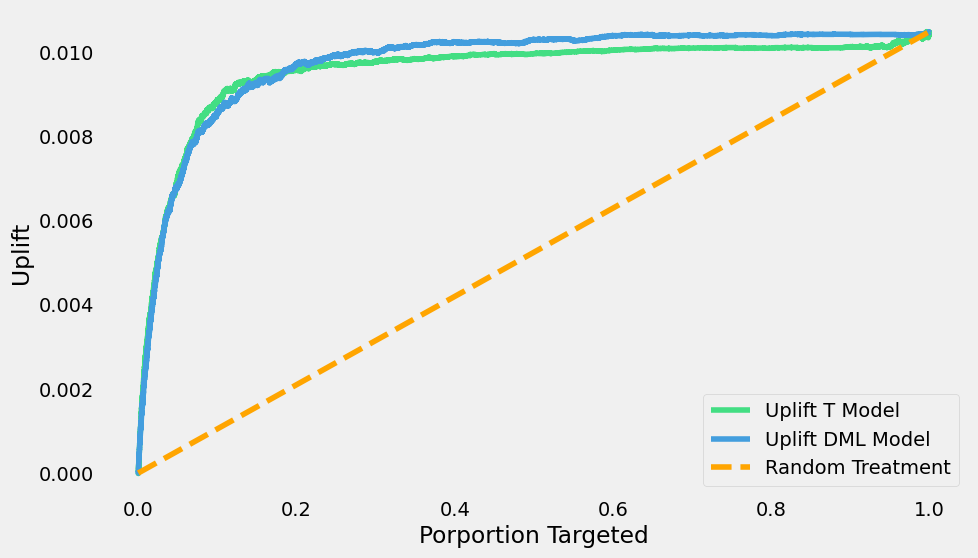

In [19]:
x_axis = df_test_sorted.percent_rank
gain_t = df_test_sorted.uplift_t
gain_dml = df_test_sorted.uplift_dml
# Plot the data

fig = plt.figure(figsize=(10, 6))
#mpl.rcParams["font.size"] = 8

ax = plt.plot(x_axis, gain_t, color="#43de83", label="Uplift T Model")

plt.plot(x_axis, gain_dml, color="#439ede", label="Uplift DML Model")

plt.plot(
    [0, x_axis.max()],
    [0, gain_t.max()],
    "--",
    color="orange",
    label="Random Treatment",
)

#plt.plot(gain_x, gain_dml, color="darkblue", label="Uplift DML Model")

plt.legend()
plt.xlabel("Porportion Targeted")
plt.ylabel("Uplift")
plt.grid()

In [ ]:
auuc_df = auuc_score(df_test_sorted, outcome_col='outcome', treatment_col='treatment')
pd.DataFrame({"Uplift Model": ["T", "DML"], "AUUC": [auuc_df["ite_t"], auuc_df["ite_dml"]]})

,Uplift Model,AUUC
0,T,0.8351
1,DML,0.8375


## Hyper-parameter optimization

The above models did quite well, but we can likely improve them by doing a grid-search across several of the hyper-parameters. In this let's try varying the max-depth, the learning rate, and the L2-regularization term.

- max-depth: [2, 6, 9, 12] - 6 is the default in XGBoost
- learning rate: [0.1, 0.3, 0.6] - 0.3 is the default
- L2-regularization term: [0, 0.5, 1, 2] - 1 is the default

In [ ]:
max_depth_values = [2, 6, 9, 12]
learning_rate_values = [0.1, 0.3, 0.6]
reg_lambda_values = [0, 0.5, 1, 2]
results = pd.DataFrame({'max_depth': [], 'learning_rate': [], 'reg_lambda': [], 'auuc': []})

for max_depth in max_depth_values:
    for learning_rate in learning_rate_values:
        for reg_lambda in reg_lambda_values:
            t_learner = BaseTClassifier(learner=XGBClassifier(max_depth=max_depth, learning_rate = learning_rate, reg_lambda = reg_lambda, random_state=42))
            t_learner.fit(X_train, T_train, y_train)
            ite_test = t_learner.predict(X_test)
            ite_test = [value[0] for value in ite_test]
            df_test = pd.DataFrame({"treatment": T_test, "ite": ite_test, "outcome": y_test})
            df_test_sorted = df_test.sort_values(by='ite', ascending=False)
            this_score = auuc_score(df_test_sorted, outcome_col='outcome', treatment_col='treatment')
            this_result = pd.DataFrame({
                'max_depth': [max_depth], 
                'learning_rate': [learning_rate], 
                'reg_lambda': [reg_lambda],
                'auuc': [this_score['ite']]
            })
            results = pd.concat([results, this_result], axis=0)

results.sort_values(by='auuc', ascending=False).head(3)

,max_depth,learning_rate,reg_lambda,auuc
0,2.0000,0.1000,0.5000,0.8527
0,2.0000,0.1000,1.0000,0.8496
0,2.0000,0.1000,0.0000,0.8485


The optimal hyper-parameters for the T-Learning model are: max_depth = 2, learning_rate = 0.1, and L2-regularization to 0.5. Next, let's find the optimal hyper-paramters for the DML model.

In [25]:
max_depth_values = [2, 6, 9, 12]
learning_rate_values = [0.1, 0.3, 0.6]
reg_lambda_values = [0, 0.5, 1, 2]
results_2 = pd.DataFrame({'max_depth': [], 'learning_rate': [], 'reg_lambda': [], 'auuc': []})

for max_depth in max_depth_values:
    for learning_rate in learning_rate_values:
        for reg_lambda in reg_lambda_values:
            model_dml = DML(
                model_y=XGBRegressor(max_depth=max_depth, learning_rate = learning_rate, reg_lambda = reg_lambda, random_state=42),
                model_t=XGBClassifier(max_depth=max_depth, learning_rate = learning_rate, reg_lambda = reg_lambda, random_state=42),
                model_final=StatsModelsLinearRegression(fit_intercept=False),
                discrete_treatment=True
            )
            model_dml.fit(y_train, T_train, X=X_train)
            ite_test = model_dml.effect(X_test)
            df_test = pd.DataFrame({"treatment": T_test, "ite": ite_test, "outcome": y_test})
            df_test_sorted = df_test.sort_values(by='ite', ascending=False)
            this_score = auuc_score(df_test_sorted, outcome_col='outcome', treatment_col='treatment')
            this_result = pd.DataFrame({
                'max_depth': [max_depth], 
                'learning_rate': [learning_rate], 
                'reg_lambda': [reg_lambda],
                'auuc': [this_score['ite']]
            })
            results_2 = pd.concat([results_2, this_result], axis=0)

results_2.sort_values(by='auuc', ascending=False).head(3)

,max_depth,learning_rate,reg_lambda,auuc
0,6.0000,0.6000,2.0000,0.8385
0,6.0000,0.6000,0.0000,0.8382
0,9.0000,0.6000,1.0000,0.8381


The optimal hyper-parameters for the DML model are: max_depth = 6, learning_rate = 0.6, and L2-regularization to 2. Finally, let's run the two models again with their respective optimal hyper-parameter settings and plot the final result.

## Run again with best parameter setting

In [26]:
# Run the T-Learning model with optimal hyper parameters
model_t = BaseTClassifier(learner=XGBClassifier(max_depth=2, learning_rate = 0.1, reg_lambda = 0.5, random_state=42))
model_t.fit(X_train, T_train, y_train)
ite_t = model_t.predict(X_test)
ite_t = [value[0] for value in ite_t]
# Run the DML model with optimal hyper parameters
model_dml = DML(
    model_y=XGBRegressor(max_depth=6, learning_rate = 0.6, reg_lambda = 2, random_state=42),
    model_t=XGBClassifier(max_depth=6, learning_rate = 0.6, reg_lambda = 2, random_state=42),
    model_final=StatsModelsLinearRegression(fit_intercept=False),
    discrete_treatment=True
)
model_dml.fit(y_train, T_train, X=X_train)
ite_dml = model_dml.effect(X_test)
df_test = pd.DataFrame({"treatment": T_test, "outcome": y_test, "ite_t": ite_t, "ite_dml": ite_dml})
C = df_test.query('treatment == 0').shape[0]  
T = df_test.query('treatment != 0').shape[0] 

# Control and treatment labels
df_test["control_outcomes"] = np.where(
    df_test["treatment"] == 0,
    df_test["outcome"],
    0,
)
df_test["treatment_outcomes"] = np.where(
    df_test["treatment"] != 0,
    df_test["outcome"],
    0,
)
df_test.head(3)

,treatment,outcome,ite_t,ite_dml,control_outcomes,treatment_outcomes
2581038,1,0,0.0004,0.0027,0,0
2409955,0,0,0.0004,0.0031,0,0
4370615,1,0,0.0003,-0.0032,0,0


In [27]:
# Sort the T-Learning results
df_test_sorted_t = df_test.sort_values(by='ite_t', ascending=False)
df_test_sorted_t["control_sum_t"] = df_test_sorted_t["control_outcomes"].cumsum() / C
df_test_sorted_t["treatment_sum_t"] = df_test_sorted_t["treatment_outcomes"].cumsum() / T
df_test_sorted_t["uplift_t"] = df_test_sorted_t["treatment_sum_t"] - df_test_sorted_t["control_sum_t"]
df_test_sorted_t['rank'] = df_test_sorted_t['ite_t'].rank(ascending=False, method='min')
df_test_sorted_t['percent_rank'] = df_test_sorted_t['rank'].rank(pct=True)
# Sort the DML results
df_test_sorted_dml = df_test.sort_values(by='ite_dml', ascending=False)
df_test_sorted_dml["control_sum_dml"] = df_test_sorted_dml["control_outcomes"].cumsum() / C
df_test_sorted_dml["treatment_sum_dml"] = df_test_sorted_dml["treatment_outcomes"].cumsum() / T
df_test_sorted_dml["uplift_dml"] = df_test_sorted_dml["treatment_sum_dml"] - df_test_sorted_dml["control_sum_dml"]
df_test_sorted_dml['rank'] = df_test_sorted_dml['ite_dml'].rank(ascending=False, method='min')
df_test_sorted_dml['percent_rank'] = df_test_sorted_dml['rank'].rank(pct=True)
df_test_sorted = pd.concat([df_test_sorted_t.reset_index(), df_test_sorted_dml.reset_index()[["uplift_dml"]]], axis=1)

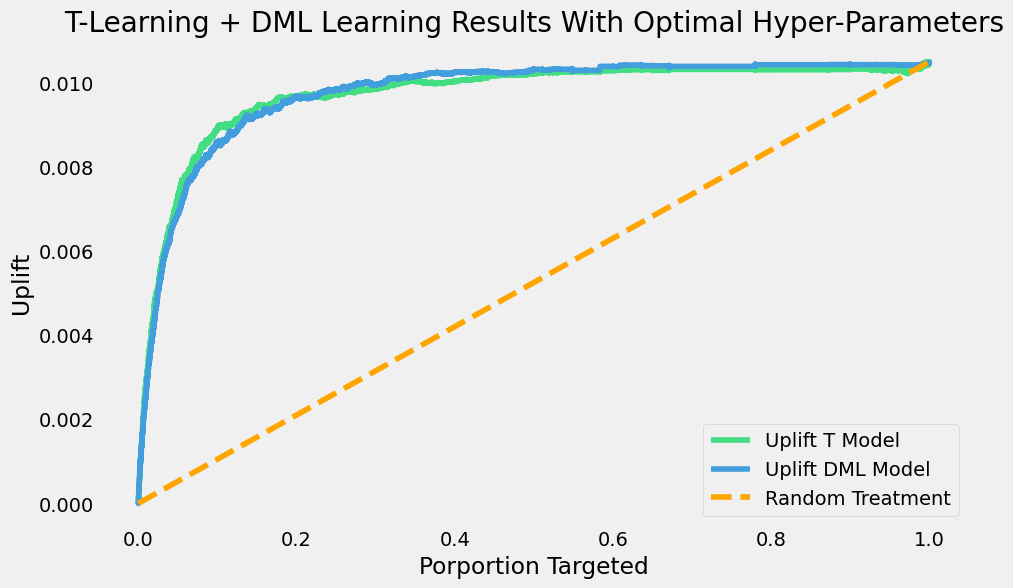

In [28]:
x_axis = df_test_sorted.percent_rank
gain_t = df_test_sorted.uplift_t
gain_dml = df_test_sorted.uplift_dml
# Plot the data

fig = plt.figure(figsize=(10, 6))
#mpl.rcParams["font.size"] = 8

ax = plt.plot(x_axis, gain_t, color="#43de83", label="Uplift T Model")

plt.plot(x_axis, gain_dml, color="#439ede", label="Uplift DML Model")

plt.plot(
    [0, x_axis.max()],
    [0, gain_t.max()],
    "--",
    color="orange",
    label="Random Treatment",
)

#plt.plot(gain_x, gain_dml, color="darkblue", label="Uplift DML Model")

plt.legend()
plt.xlabel("Porportion Targeted")
plt.ylabel("Uplift")
plt.title("T-Learning + DML Learning Results With Optimal Hyper-Parameters")
plt.grid()

## Model Conclusions
We further see that DML model achieved just about the same results with the optimal hyper-parameters, whereas the T-Learning model had an improvemnt and nearly matches it. This tells us, the DML model is the better model as it is less reliant on finding the optimal hyper-parameters to get its best results.

## Final Conclusions

We will want to target around the first 20% or 45% of the population, as these have the largest distance from the random treatment curve resulting in highest yielding gain. 

As seen from the analysis below, if we target the first 20% of individuals, they have characteristics distinct from the rest of the sample. They have lower f0, f3, f5, and f6 values, whereas they have higher f9 values. Since this data was obfuscated, we would need to map the data back to something understandable, but from this, customer with this type of segmentations are the ones we would want to target first in a marketing campaign.

In [29]:
n_test = df_test_sorted_dml.shape[0]
n_top_20_percent = round(n_test*.2)
top_20_percent_individuals = df_test_sorted_dml.reset_index()['index'].head(n_top_20_percent)
remaining_80_percent_individuals = df_test_sorted_dml.reset_index()['index'].tail(n - n_top_20_percent)

In [30]:
df_top_20 = df.reset_index().query('index in @top_20_percent_individuals')
top_20_means = df_top_20.mean().reset_index()
top_20_means.columns = ['col', 'top_20']

df_remaining_80 = df.reset_index().query('index in @remaining_80_percent_individuals')
remaining_80_means = df_remaining_80.mean().reset_index()
remaining_80_means.columns = ['col', 'remaining_80']

group_means = top_20_means.merge(remaining_80_means, how='left', on='col')
group_means

,col,top_20,remaining_80
0,index,2966483.9684,2447380.4577
1,f0,16.7576,19.6209
2,f1,10.1099,10.0700
3,f2,8.4729,8.4464
4,f3,2.4466,4.1788
5,f4,10.4912,10.3385
6,f5,3.7679,4.0285
7,f6,-8.3057,-4.1535
8,f7,5.7258,5.1012
9,f8,3.8643,3.9336
